In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet_bbox import CapsuleNetwork, CapsuleLoss, display_images
from utils_original_bbox import DICOMCoarseDataset, display_data_loader_batch, TransformBboxDataset  ,CustomTransform

In [2]:
scenario = 1
data_augmentation = False

In [3]:
BASE_DIR = "D:/Datasets/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["nodule", "non-nodule"]
train_ratio = 0.8
image_size = 80
df_bbox_coord = pd.read_csv('annotation_files.csv')
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

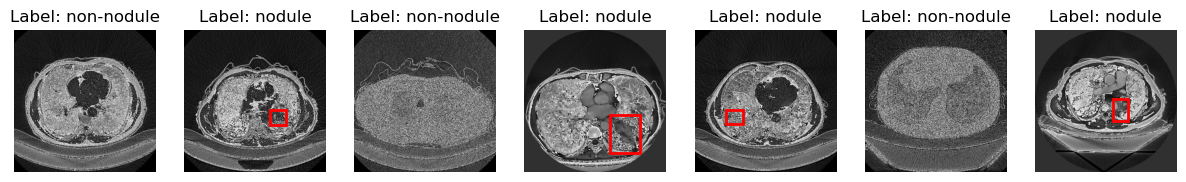

In [4]:
# train_transforms = None

# transform = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.Grayscale(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

# if data_augmentation:
#     train_transforms = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
#         transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
#                         scale=(0.8, 1.2),  # Scale for zoom in/out
#                         ratio=(0.9, 1.1)),
#         transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
#         transform
#     ])
# else: 
#     train_transforms = transform

dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=["nodule", "non-nodule"], bbox_coord=df_bbox_coord, scenario=scenario)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
dataset.visualize_images(num_images=7)

In [5]:
image, _, _ = dataset[50050]
orig_width, orig_height = image.size

type(image_size)

int

In [6]:
_, _, annotations = dataset[50000]
xmin = annotations['xmin']
annotations


{'xmin': -1, 'ymin': -1, 'xmax': -1, 'ymax': -1}

In [7]:
image=dataset[50050]

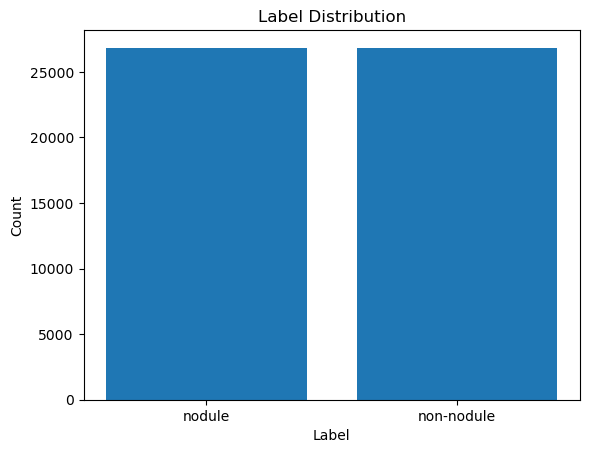

In [5]:
dataset.display_label_distribution()

In [6]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataset = TransformBboxDataset(torch.utils.data.Subset(dataset, train_dataset.indices), transform=CustomTransform(image_size))
test_dataset = TransformBboxDataset(torch.utils.data.Subset(dataset, test_dataset.indices), CustomTransform(image_size))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [10]:
train_dataset[1]

(tensor([[[-0.9451, -0.9451, -0.9451,  ..., -0.9451, -0.9451, -0.9451],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9451, -0.9451, -0.9451],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9451, -0.9451, -0.9451],
          ...,
          [-0.9451, -0.9451, -0.9451,  ..., -0.9451, -0.9451, -0.9451],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9451, -0.9451, -0.9451],
          [-0.9451, -0.9451, -0.9451,  ..., -0.9451, -0.9451, -0.9451]]]),
 1,
 (-1, -1, -1, -1))

In [1]:
data_iter = iter(train_loader)
batch = next(data_iter)
batch

NameError: name 'train_loader' is not defined

In [12]:
# Lade das erste Batch
data_iter = iter(train_loader)
images, labels, bbox = next(data_iter)
current_bbox=bbox[0]
current_bbox[0].item()
position=6
values_at_position = [tensor[position].item() for tensor in bbox]



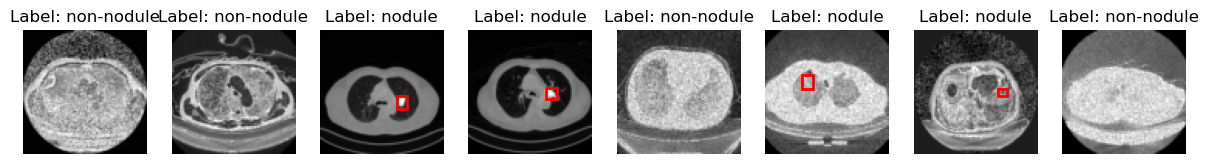

In [7]:
display_data_loader_batch(train_loader, classes)

In [8]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=6400, bias=True)
      (5): Sigmoid()
    )
    (linear_boxes_layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=16, out_features=4, bias=True)
      (5): Sigmoid()
    )
  )
)


In [9]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [10]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

TypeError: 'list' object is not callable

Test Loss: 1.30417101

Test Accuracy of     0: 95.70% (5135/5366)
Test Accuracy of     1: 89.71% (4819/5372)

Test Accuracy (Overall): 92.70% (9954/10738)


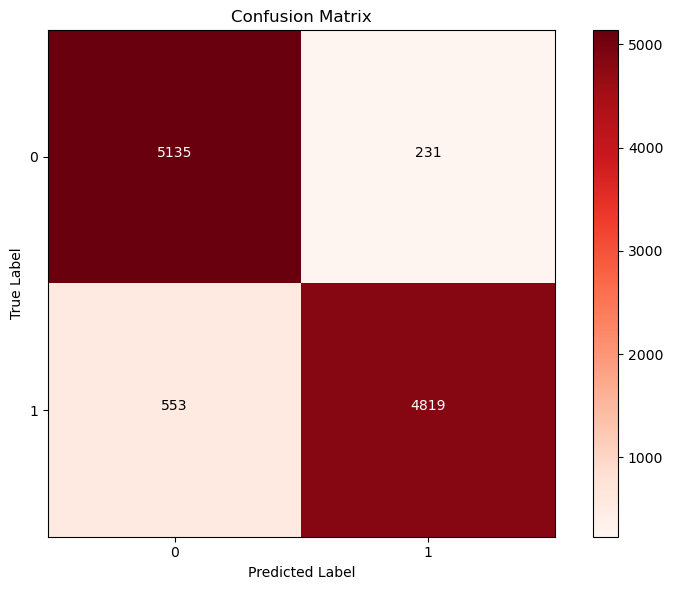

In [11]:
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

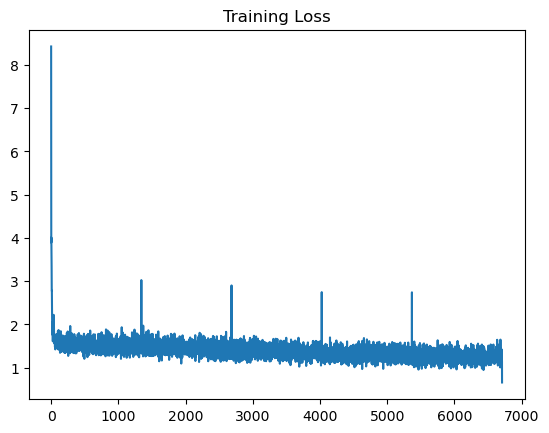

In [12]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

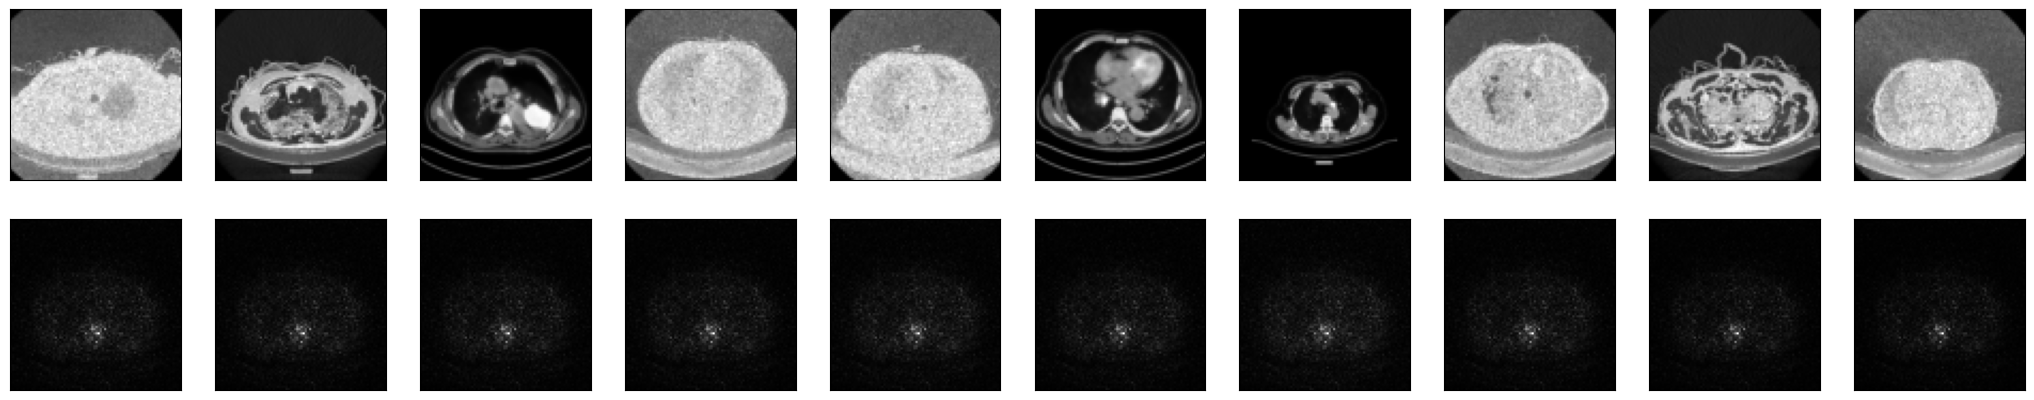

In [13]:
display_images(images, reconstructions)